In [2]:
import transformers

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas


def visualize_converge(MODELS_TO_CHOOSE, LABELS):
    fig = plt.figure(figsize=(16, 6), dpi=100)

    axes = fig.subplots(2,2, sharex='col', sharey='row')

    # ax1.set_xticks(np.linspace(min(result_df.index), max(result_df.index), num=5, dtype=int))
    #     ax1.set_xticklabels(np.linspace(min(result_df.index)+1, max(result_df.index)+1, num=5 , dtype=int))
    # axe for loss
    #ax2 = ax1.twinx()

    COLORS = ['teal', 'orange', '#e87a59', 'red',  'green', 'yellow',]

    ALPHAS = [0.5, 0.5, 0.5, 0.5, 1]#np.linspace(0.1, 1, num=len(MODELS_TO_CHOOSE), dtype=float)

    for j in range(len(axes)): # num of columns in a row
        label = LABELS[j]
        
        for i, MODEL in enumerate(MODELS_TO_CHOOSE):
            result_df = pandas.read_csv(f'result_data/{MODEL}_{label}.csv')
            sns.lineplot(data=result_df, x='iteration', y='accuracy', label=f'{MODEL}', color=COLORS[i], alpha=ALPHAS[i], ax=axes[0][j], linestyle='-', linewidth=2,)
            sns.lineplot(data=result_df, x='iteration', y='loss', label=f'{MODEL}', color=COLORS[i], alpha=ALPHAS[i], ax=axes[1][j], linestyle='-', linewidth=2)

        if label== "1":
            axes[0][j].set_title('Positive Examples')
            axes[1][j].set_title('Positive Examples')
        elif label == "0":
            axes[0][j].set_title('Negative Examples')
            axes[1][j].set_title('Negative Examples')
        axes[0][j].legend([],[], frameon=False)
        axes[1][j].legend([],[], frameon=False)
        axes[0][j].set_ylabel('Accuracy')
        axes[0][j].set_xlabel('Iteration')
        axes[1][j].set_ylabel('Loss')
        axes[1][j].set_xlabel('Iteration')


    handles, labels = axes[0][1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()


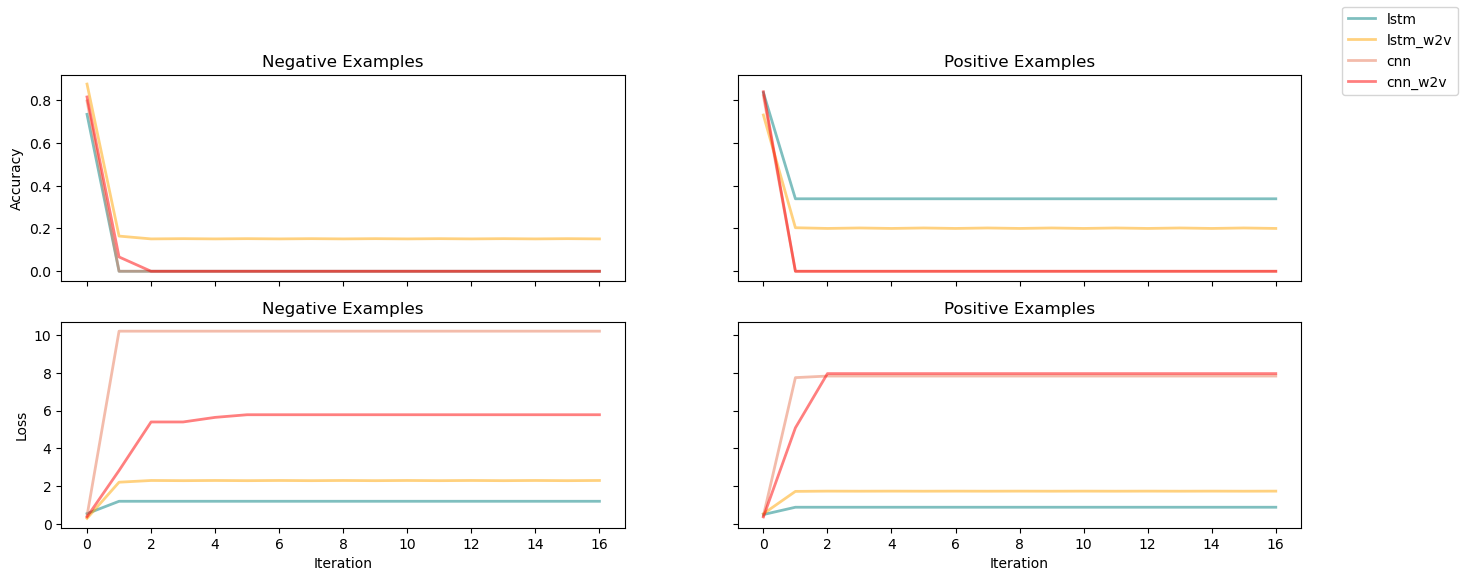

In [4]:
MODELS_TO_CHOOSE = ['lstm', 'lstm_w2v', 'cnn', 'cnn_w2v', ] #'cnn_tanh', 'finetuned_bert'
LABELS = ["0", "1"]
visualize_converge(MODELS_TO_CHOOSE, LABELS)

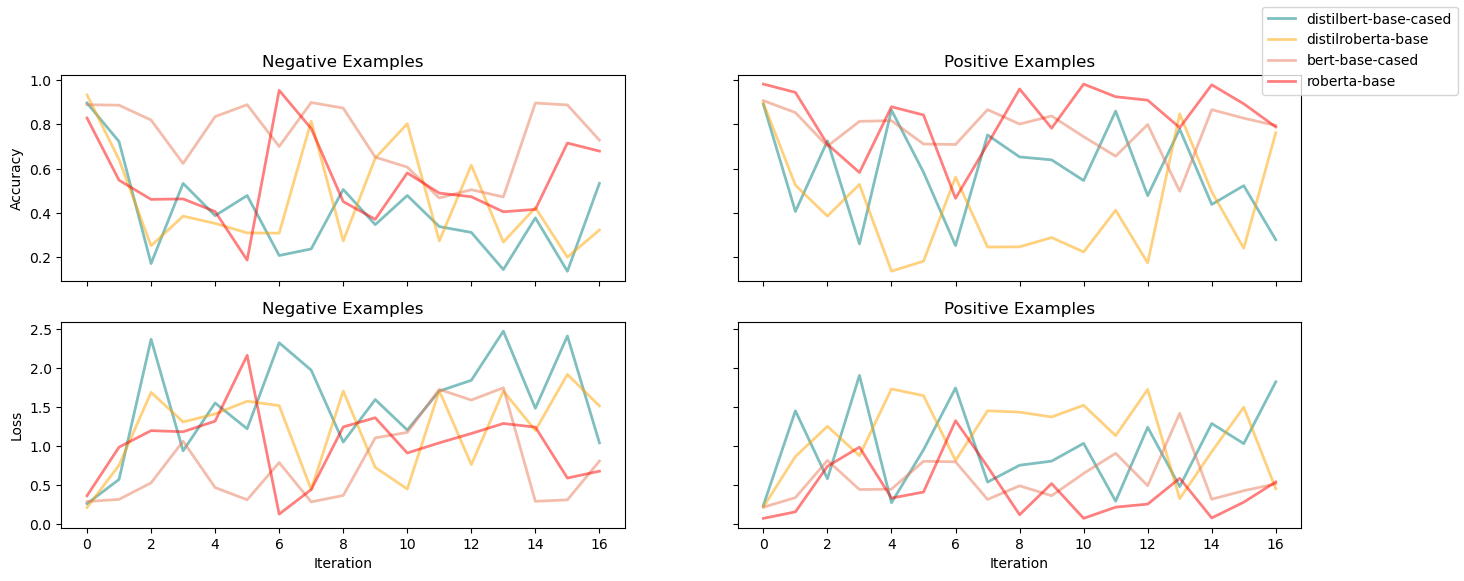

In [8]:
MODELS_TO_CHOOSE = ['distilbert-base-cased',  'distilroberta-base', 'bert-base-cased', 'roberta-base',  ] #'cnn_tanh', 'finetuned_bert'
LABELS = ["0", "1"]
visualize_converge(MODELS_TO_CHOOSE, LABELS)

In [10]:
import pandas as pd
EXPERIMENT_VERSION_CODE = 'distill'
label = 0

df_acc = pd.read_csv(f'result_data/transfer_acc_{EXPERIMENT_VERSION_CODE}_{str(label)}.csv', index_col=0)
df_loss =pd.read_csv(f'result_data/transfer_loss_{EXPERIMENT_VERSION_CODE}_{str(label)}.csv', index_col=0)
figure = plt.figure(figsize=(16, 6))
axes = figure.subplots(2, 1)
sns.heatmap(df_acc, ax=axes[0])
sns.heatmap(df_loss, ax=axes[1])
plt.show()

ValueError: could not convert string to float: 'distilbert-base-cased'